## Further modeling - Tadpole challenge 

In this Notebook different models will be used on the numerical dataset 
We will use the already modified dataset which only contains the data from the first visit. Further, we will test it also separately on other data and the brain data only. 

In [1]:
# Load the required packages 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer

# Import TensorFlow packages 

import tensorflow as tf   
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

In [2]:
# Import packages to see models in MLFlow 
import logging
import parsenvy

from logging import getLogger
import mlflow
from config_tp import TRACKING_URI, EXPERIMENT_NAME
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/56', experiment_id='56', lifecycle_stage='active', name='alzbusters_numeric_models', tags={}>

In [3]:
# Load the processed dataset 
df=pd.read_csv('../tadpole_challenge/df_processed.csv')

In [4]:
#Drop all the empty rows and columns with the weird entries 
df.dropna(axis=0, inplace=True)

#drop the column with the IDs and strange symbols
df.drop(columns=df[['PTID','ABETA','PTAU']], inplace=True)

In [5]:
#Convert everything to numerical values 
df[['TAU']].astype(float)

,TAU
18,101.20
19,170.40
30,347.80
36,324.80
90,108.20
...,...
1792,279.90
1793,314.60
1794,305.00
1796,300.10


In [6]:
# Use get_dummies for the PTGENDER and APOE4 column 
df=pd.get_dummies(df, columns=['PTGENDER', 'APOE4'], drop_first=False)

In [7]:
df.isnull().sum()

Unnamed: 0         0
AGE                0
FDG                0
AV45               0
TAU                0
CDRSB              0
ADAS11             0
ADAS13             0
MMSE               0
RAVLT_immediate    0
Ventricles         0
Hippocampus        0
WholeBrain         0
Entorhinal         0
MidTemp            0
DX                 0
PTGENDER_Female    0
PTGENDER_Male      0
APOE4_0.0          0
APOE4_1.0          0
APOE4_2.0          0
dtype: int64

In [8]:
df["TAU"].replace("<80",np.nan, inplace=True)
df["TAU"].replace(">1300",np.nan, inplace=True)

In [9]:
#Convert the entries in DX into 0-2 values 
def replace_dx(df, feature):
    df[feature] = df[feature].replace('CN', 0)
    df[feature] = df[feature].replace('MCI', 1)
    df[feature] = df[feature].replace('Dementia', 2)
    return df

col_pass = ['DX']

for col in col_pass: 
    df = replace_dx(df, col)

In [10]:
# Train-test split 

X=df.drop('DX', axis=1)
y=df['DX']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, random_state=42)

In [11]:
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

In [12]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='1_SVM_scaled')
run = mlflow.active_run()

In [13]:
# Start with a SVM model 
model = SVC(kernel='rbf')
model.fit(X_train_scaled, y_train)

SVC()

In [14]:
y_pred=model.predict(X_test_scaled)

In [15]:
# Check out the metrics
acc_test = accuracy_score(y_test, y_pred)
print(acc_test)
acc_train=accuracy_score(y_train, model.predict(X_train_scaled))
print(acc_train)

0.821656050955414
0.9465811965811965


In [16]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.821656050955414, 'train-accuracy': 0.9465811965811965}, params={}, tags={'mlflow.runName': '1_SVM_scaled',
 'mlflow.source.git.commit': 'd605302d01200a4536da993e7ae45ed46232dc60',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/ae0416924545459194a17cba06626e13/artifacts', end_time=1661779923261, experiment_id='56', lifecycle_stage='active', run_id='ae0416924545459194a17cba06626e13', run_uuid='ae0416924545459194a17cba06626e13', start_time=1661779923035, status='FINISHED', user_id='tamarapallien'>>

In [17]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='2_KNN_scaled')
run = mlflow.active_run()

In [18]:
# Train a KNN model 
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_scaled, np.ravel(y_train))

KNeighborsClassifier(metric='euclidean')

In [19]:
y_pred=knn.predict(X_test_scaled)

# Check out the metrics
acc_test = accuracy_score(y_test, y_pred)
print(acc_test)
acc_train=accuracy_score(y_train, model.predict(X_train_scaled))
print(acc_train)

0.6751592356687898
0.9465811965811965


/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [20]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.6751592356687898, 'train-accuracy': 0.9465811965811965}, params={}, tags={'mlflow.runName': '2_KNN_scaled',
 'mlflow.source.git.commit': 'd605302d01200a4536da993e7ae45ed46232dc60',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/2079dd923097433e9727c4a80ccd00f1/artifacts', end_time=1661779923823, experiment_id='56', lifecycle_stage='active', run_id='2079dd923097433e9727c4a80ccd00f1', run_uuid='2079dd923097433e9727c4a80ccd00f1', start_time=1661779923432, status='FINISHED', user_id='tamarapallien'>>

In [21]:
#Try out as simple DNN model 
mlflow.start_run(run_name='3_DNN_scaled')
run = mlflow.active_run()

In [22]:
X_train=np.asarray(X_train_scaled).astype(np.float32)
y_train=np.asarray(y_train).astype(np.float32)

In [23]:
# Built a model 
model=Sequential()
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-08-29 15:32:04.090009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-29 15:32:04.090283: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
#Compile model 

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
#Train the model 
training = model.fit(X_train_scaled, y_train, batch_size=48, validation_split=0.2, epochs=200)

Epoch 1/200


2022-08-29 15:32:04.330249: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-29 15:32:04.583001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 31ms/step - loss: 0.7197 - accuracy: 0.4251 - val_loss: 0.5331 - val_accuracy: 0.4894
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.5881 - accuracy: 0.4572 - val_loss: 0.3870 - val_accuracy: 0.4894
Epoch 3/200
1/8 [==>...........................] - ETA: 0s - loss: 0.4864 - accuracy: 0.6667

2022-08-29 15:32:04.942848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 9ms/step - loss: 0.4503 - accuracy: 0.5535 - val_loss: 0.2661 - val_accuracy: 0.5426
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.3670 - accuracy: 0.5535 - val_loss: 0.1516 - val_accuracy: 0.5638
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.2791 - accuracy: 0.5722 - val_loss: 0.0352 - val_accuracy: 0.5851
Epoch 6/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1633 - accuracy: 0.6096 - val_loss: -0.0972 - val_accuracy: 0.6170
Epoch 7/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0605 - accuracy: 0.6096 - val_loss: -0.2437 - val_accuracy: 0.6277
Epoch 8/200
8/8 [==============================] - 0s 9ms/step - loss: -0.0910 - accuracy: 0.6203 - val_loss: -0.4041 - val_accuracy: 0.6489
Epoch 9/200
8/8 [==============================] - 0s 9ms/step - loss: -0.1969 - accuracy: 0.6123 - val_loss: -0.6043 - val_accuracy: 0.6596
Epoch 10/200
8/8 [===============

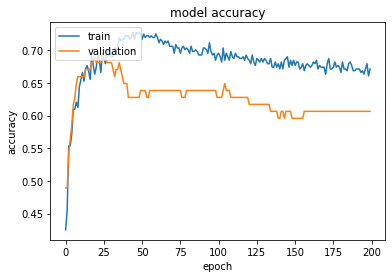

In [26]:
# summarize history for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

2022-08-29 15:32:20.009970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


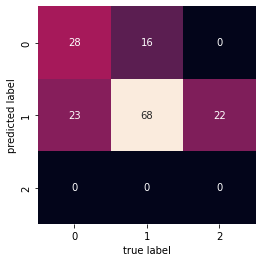

In [27]:
y_predd = model.predict(X_test_scaled)
y_pred = (y_predd>0.5).astype(int)

# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [28]:
# Check out the metrics
acc_train = accuracy_score(y_train, model.predict(X_train_scaled).astype(int))
acc_test = accuracy_score(y_test, y_pred.round())
print(acc_test)


0.6114649681528662


In [29]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.6114649681528662, 'train-accuracy': 0.6388888888888888}, params={}, tags={'mlflow.runName': '3_DNN_scaled',
 'mlflow.source.git.commit': 'd605302d01200a4536da993e7ae45ed46232dc60',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/76948f82defa46fb8ecc4b61d38104d4/artifacts', end_time=1661779940290, experiment_id='56', lifecycle_stage='active', run_id='76948f82defa46fb8ecc4b61d38104d4', run_uuid='76948f82defa46fb8ecc4b61d38104d4', start_time=1661779923981, status='FINISHED', user_id='tamarapallien'>>

In [30]:
#Try out as simple DNN model 
mlflow.start_run(run_name='4_SVM_gs_scaled')
run = mlflow.active_run()

In [31]:
# Since the SVM performed the best we will perform a GridSearch to see if we can improve our outcome 
# Define hyperparameter grid 
param_grid = [{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto', 'scale'],
               'C': [0.01, 0.1, 1, 10, 100],
               'degree': [2, 3, 4]
              }]

gs = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto',
                                    'scale'],
                          'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}],
             scoring='accuracy', verbose=1)

In [32]:
# Print best parameters 
print('Best Parameters:', gs.best_params_)

Best Parameters: {'C': 1, 'degree': 2, 'gamma': 0.0001, 'kernel': 'linear'}


In [33]:
# Print best score
print('Best accuracy', gs.best_score_.round(3))

Best accuracy 0.947


In [34]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [35]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(acc_test)

0.8980891719745223


In [36]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.8980891719745223, 'train-accuracy': 0.9615384615384616}, params={}, tags={'mlflow.runName': '4_SVM_gs_scaled',
 'mlflow.source.git.commit': 'd605302d01200a4536da993e7ae45ed46232dc60',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/c1d651cb4d1249bfa3df7de01d9b3bd6/artifacts', end_time=1661779945257, experiment_id='56', lifecycle_stage='active', run_id='c1d651cb4d1249bfa3df7de01d9b3bd6', run_uuid='c1d651cb4d1249bfa3df7de01d9b3bd6', start_time=1661779940456, status='FINISHED', user_id='tamarapallien'>>

In [37]:
#Load the df_other dataframe 
df_other=pd.read_csv('../tadpole_challenge/df_other.csv')

In [38]:
df_other.shape

(2122, 11)

In [39]:
X_other= df_other.drop('DX', axis=1)
y_other=df_other['DX']
X_train_other, X_test_other, y_train_other, y_test_other=train_test_split(X_other, y_other, random_state=42, stratify=y_other)

In [40]:
X_train_other['AGE'].fillna(X_train_other['AGE'].mean(), inplace=True);
X_test_other['AGE'].fillna(X_train_other['AGE'].mean(), inplace=True);

In [41]:
#Use the KNN imputer to fill the other missing values in the X_train and apply this to X_test 
#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train_other)

# transform X_train und X_test
X_train_other_trans = imputer.transform(X_train_other)
X_test_other_trans = imputer.transform(X_test_other)

In [42]:
scaler = StandardScaler()
X_train_other_trans_scaled=scaler.fit_transform(X_train_other_trans)
X_test_other_trans_scaled=scaler.transform(X_test_other_trans)

In [43]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='5_SVM_other_scaled_trans')
run = mlflow.active_run()

In [44]:
# Start with a SVM model 
model = SVC(kernel='rbf')
model.fit(X_train_other_trans_scaled, y_train_other)

SVC()

In [45]:
y_pred=model.predict(X_test_other_trans_scaled)

In [46]:
# Check out the metrics
acc_test = accuracy_score(y_test_other, y_pred)
print(acc_test)
acc_train=accuracy_score(y_train_other, model.predict(X_train_other_trans_scaled))
print(acc_train)

0.9152542372881356
0.9296040226272785


In [47]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.9152542372881356, 'train-accuracy': 0.9296040226272785}, params={}, tags={'mlflow.runName': '5_SVM_other_scaled_trans',
 'mlflow.source.git.commit': 'd605302d01200a4536da993e7ae45ed46232dc60',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/11b00a437afc4e5ea250ce17a0ecac02/artifacts', end_time=1661779946043, experiment_id='56', lifecycle_stage='active', run_id='11b00a437afc4e5ea250ce17a0ecac02', run_uuid='11b00a437afc4e5ea250ce17a0ecac02', start_time=1661779945723, status='FINISHED', user_id='tamarapallien'>>

In [48]:
#Try the GridSearch on df_other 
#Try out as simple DNN model 
mlflow.start_run(run_name='6_SVM_gs_other_scaled_trans')
run = mlflow.active_run()

In [49]:
# Since the SVM performed the best we will perform a GridSearch to see if we can improve our outcome 
# Define hyperparameter grid 
param_grid = [{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto', 'scale'],
               'C': [0.01, 0.1, 1, 10, 100],
               'degree': [2, 3, 4]
              }]

gs = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

gs.fit(X_train_other_trans_scaled, y_train_other)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto',
                                    'scale'],
                          'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}],
             scoring='accuracy', verbose=1)

In [50]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_other_trans_scaled)

In [51]:
# Check out the metrics
acc_train = accuracy_score(y_train_other, best_model.predict(X_train_other_trans_scaled))
acc_test = accuracy_score(y_test_other, y_pred_tuned)
print(acc_test)

0.9246704331450094


In [52]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.9246704331450094, 'train-accuracy': 0.9327467001885607}, params={}, tags={'mlflow.runName': '6_SVM_gs_other_scaled_trans',
 'mlflow.source.git.commit': 'd605302d01200a4536da993e7ae45ed46232dc60',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/4ea6893f19954f7d967d8284296c8a94/artifacts', end_time=1661779992644, experiment_id='56', lifecycle_stage='active', run_id='4ea6893f19954f7d967d8284296c8a94', run_uuid='4ea6893f19954f7d967d8284296c8a94', start_time=1661779946206, status='FINISHED', user_id='tamarapallien'>>